In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# for now this is defined here bc we use it to set up constants
def get_subpaths(path, length):
    ''' Given a path, return a set of all sub-paths of the specified length. '''
    return {tuple(path[i:i + length]) for i in range(len(path) - length + 1)}


################################# Set up all of our constants #################################

# Barriers can exist in any open hex, excluding the hexes right next to the reward ports
POSSIBLE_BARRIERS = np.arange(5, 48)
POSSIBLE_BARRIERS = POSSIBLE_BARRIERS[~np.isin(POSSIBLE_BARRIERS, [5, 6, 33, 38, 43, 47])]

# Minimum distance from port to critical choice point = 6 (including port hex)
ILLEGAL_CHOICE_POINTS_6 = [4, 6, 5, 11, 8, 10, 7, 9, 49, 38, 47, 32, 42, 27, 37, 46, 48, 43, 33, 39, 28, 44, 34, 23]

# Max straight path length to reward port = 6 hexes. (illegal paths are 7+)
MAX_STRAIGHT_PATH_TO_PORT = 6
STRAIGHT_PATHS_TO_PORTS = [[1, 4, 6, 8, 11, 14, 18, 22, 27, 32, 38, 49, 2], 
                  [1, 4, 5, 7, 9, 12, 15, 19, 23, 28, 33, 48, 3],
                  [2, 49, 47, 42, 46, 41, 45, 40, 44, 39, 43, 48, 3]]
# Max straight path length inside maze = 6 hexes. (illegal paths are 7+)
MAX_STRAIGHT_PATH_INSIDE_MAZE = 6
STRAIGHT_PATHS_INSIDE_MAZE = [[5, 7, 10, 13, 17, 21, 26, 31, 37, 42, 47],
                              [9, 12, 16, 20, 25, 30, 36, 41, 46],
                              [6, 8, 10, 13, 16, 20, 24, 29, 34, 39, 43],
                              [11, 14, 17, 21, 25, 30, 35, 40, 44],
                              [38, 32, 37, 31, 36, 30, 35, 29, 34, 28, 33],
                              [27, 22, 26, 21, 25, 20, 24, 19, 23]]

# Get all illegal straight paths to ports
illegal_straight_paths_list = []
for path in STRAIGHT_PATHS_TO_PORTS:
    for sub_path in get_subpaths(path, MAX_STRAIGHT_PATH_TO_PORT+1):
        illegal_straight_paths_list.append(sub_path)

# Store illegal straight paths as a set of tuples for O(1) lookup time
ILLEGAL_STRAIGHT_PATHS_TO_PORT = {tuple(path) for path in illegal_straight_paths_list}

# Get all illegal straight paths inside the maze
illegal_straight_paths_list = []
for path in STRAIGHT_PATHS_INSIDE_MAZE:
    for sub_path in get_subpaths(path, MAX_STRAIGHT_PATH_INSIDE_MAZE+1):
        illegal_straight_paths_list.append(sub_path)

# Store illegal straight paths as a set of tuples for O(1) lookup time
ILLEGAL_STRAIGHT_PATHS_INSIDE_MAZE = {tuple(path) for path in illegal_straight_paths_list}

################################# Define a bunch of functions #################################

def create_hex_maze():
    '''
    Use networkx to create a graph representing the empty hex maze before any barriers are added.
    
    Returns: a new networkx graph representing all of the hexes in the hex maze
    ''' 
    empty_hex_maze = nx.Graph()
    
    # Define all nodes and edges to create the empty maze
    add_edges_to_node(empty_hex_maze, 1, [4])
    add_edges_to_node(empty_hex_maze, 4, [1, 5, 6])
    add_edges_to_node(empty_hex_maze, 6, [4, 8])
    add_edges_to_node(empty_hex_maze, 5, [4, 7])
    add_edges_to_node(empty_hex_maze, 8, [6, 11, 10])
    add_edges_to_node(empty_hex_maze, 7, [5, 10, 9])
    add_edges_to_node(empty_hex_maze, 11, [8, 14])
    add_edges_to_node(empty_hex_maze, 10, [8, 7, 13])
    add_edges_to_node(empty_hex_maze, 9, [7, 12])
    add_edges_to_node(empty_hex_maze, 14, [11, 18, 17])
    add_edges_to_node(empty_hex_maze, 13, [10, 17, 16])
    add_edges_to_node(empty_hex_maze, 12, [9, 16, 15])
    add_edges_to_node(empty_hex_maze, 18, [14, 22])
    add_edges_to_node(empty_hex_maze, 17, [14, 13, 21])
    add_edges_to_node(empty_hex_maze, 16, [13, 12, 20])
    add_edges_to_node(empty_hex_maze, 15, [12, 19])
    add_edges_to_node(empty_hex_maze, 22, [18, 27, 26])
    add_edges_to_node(empty_hex_maze, 21, [17, 26, 25])
    add_edges_to_node(empty_hex_maze, 20, [16, 25, 24])
    add_edges_to_node(empty_hex_maze, 19, [15, 24, 23])
    add_edges_to_node(empty_hex_maze, 27, [22, 32])
    add_edges_to_node(empty_hex_maze, 26, [22, 21, 31])
    add_edges_to_node(empty_hex_maze, 25, [21, 20, 30])
    add_edges_to_node(empty_hex_maze, 24, [20, 19, 29])
    add_edges_to_node(empty_hex_maze, 23, [19, 28])
    add_edges_to_node(empty_hex_maze, 32, [27, 38, 37])
    add_edges_to_node(empty_hex_maze, 31, [26, 37, 36])
    add_edges_to_node(empty_hex_maze, 30, [25, 36, 35])
    add_edges_to_node(empty_hex_maze, 29, [24, 35, 34])
    add_edges_to_node(empty_hex_maze, 28, [23, 34, 33])
    add_edges_to_node(empty_hex_maze, 38, [32, 49])
    add_edges_to_node(empty_hex_maze, 37, [31, 32, 42])
    add_edges_to_node(empty_hex_maze, 36, [30, 31, 41])
    add_edges_to_node(empty_hex_maze, 35, [29, 30, 40])
    add_edges_to_node(empty_hex_maze, 34, [28, 29, 39])
    add_edges_to_node(empty_hex_maze, 33, [28, 48])
    add_edges_to_node(empty_hex_maze, 49, [2, 38, 47])
    add_edges_to_node(empty_hex_maze, 42, [37, 46, 47])
    add_edges_to_node(empty_hex_maze, 41, [36, 45, 46])
    add_edges_to_node(empty_hex_maze, 40, [35, 44, 45])
    add_edges_to_node(empty_hex_maze, 39, [34, 43, 44])
    add_edges_to_node(empty_hex_maze, 48, [3, 33, 43])
    add_edges_to_node(empty_hex_maze, 2, [49])
    add_edges_to_node(empty_hex_maze, 47, [49, 42])
    add_edges_to_node(empty_hex_maze, 46, [42, 41])
    add_edges_to_node(empty_hex_maze, 45, [41, 40])
    add_edges_to_node(empty_hex_maze, 44, [40, 39])
    add_edges_to_node(empty_hex_maze, 43, [39, 48])
    add_edges_to_node(empty_hex_maze, 3, [48])
    return empty_hex_maze
    

def add_edges_to_node(graph, node, edges):
    '''
    Add all edges to the specified node in the graph. 
    If the node does not yet exist in the graph, add the node.
    '''
    for edge in edges:
        graph.add_edge(node, edge)
        
def find_all_critical_choice_points(graph):
    '''
    Given a graph representing the hex maze, 
    find all critical choice points between reward ports 1, 2, and 3.
    
    Returns: a set of all critical choice points
    '''
    paths12 = list(nx.all_shortest_paths(graph, source=1, target=2))
    paths13 = list(nx.all_shortest_paths(graph, source=1, target=3))
    paths23 = list(nx.all_shortest_paths(graph, source=2, target=3))
    
    choice_points = set()
    # all choice points from port 1
    for path_a in paths12:
        for path_b in paths13:
            shared_path = [hex for hex in path_a if hex in path_b]
            choice_points.add(shared_path[-1])
    
    # all choice points from port 2
    for path_a in paths12:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b]
            choice_points.add(shared_path[-1])
            
    # all choice points from port 3
    for path_a in paths13:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b[::-1]]
            choice_points.add(shared_path[-1])
    return choice_points


def has_illegal_straight_path(graph):
    '''
    Given a graph of the hex maze, checks if there are any illegal straight paths.
    Returns: the (first) offending path, or False if none
    '''
    optimal_paths = []
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=1, target=2)))
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=1, target=3)))
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=2, target=3)))

    # We do 2 separate checks here beacause we may have different path length critera
    # for paths to reward ports vs inside the maze
    
    # First check all subpaths against illegal paths to a reward port
    subpaths1 = set()
    for path in optimal_paths:
        subpaths1.update(get_subpaths(path, MAX_STRAIGHT_PATH_TO_PORT+1))

    for path in subpaths1:
        if path in ILLEGAL_STRAIGHT_PATHS_TO_PORT:
            return path # (equivalent to returning True)
        
    # Now check all subpaths against illegal paths inside the maze
    subpaths2 = set()
    for path in optimal_paths:
        subpaths2.update(get_subpaths(path, MAX_STRAIGHT_PATH_INSIDE_MAZE+1))

    for path in subpaths2:
        if path in ILLEGAL_STRAIGHT_PATHS_INSIDE_MAZE:
            return path # (equivalent to returning True)
    
    # If we did all of those checks and found no straight paths, we're good to go!
    return False


def is_valid_maze(graph, complain=False):
    '''
    Given a graph representing a possible hex maze configuration, check if it is valid 
    using the following criteria: 
    - there are no unreachable hexes (includes that all reward ports are reachable)
    - path lengths between reward ports are between 15-25 hexes
    - all critical choice points are >=6 hexes away from a reward port
    - there are a maximum of 3 critical choice points
    - no straight paths >MAX_STRAIGHT_PATH_TO_PORT hexes to reward port (including port hex)
    - no straight paths >STRAIGHT_PATHS_INSIDE_MAZE in middle of maze
    
    Optional argument complain (defaults to False):
    - When True: If our maze configuration is invalid, print out the reason why.
    
    Returns: True if the hex maze is valid, False otherwise
    '''

    # Make sure all (non-barrier) hexes are reachable
    if not nx.is_connected(graph):
        if complain:
            print("BAD MAZE: At least one (non-barrier) hex is unreachable")
        return False
    
    # Make sure path lengths are between 15-25
    len12 = nx.shortest_path_length(graph, source=1, target=2)
    len13 = nx.shortest_path_length(graph, source=1, target=3)
    len23 = nx.shortest_path_length(graph, source=2, target=3)
    reward_port_lengths = [len12, len13, len23]
    if min(reward_port_lengths) <= 13:
        if complain:
            print("BAD MAZE: Path between reward ports is too short (<=13)")
        return False
    if max(reward_port_lengths) - min(reward_port_lengths) < 4:
        if complain:
            print("BAD MAZE: Distance difference in reward port paths is too small (<4)")
        return False
    if max(reward_port_lengths) > 25:
        if complain:
            print("BAD MAZE: Path between reward ports is too long (>25)")
        return False

    # Make sure all critical choice points are >=6 hexes away from a reward port
    choice_points = find_all_critical_choice_points(graph)
    if any(hex in ILLEGAL_CHOICE_POINTS_6 for hex in choice_points):
        if complain:
            print("BAD MAZE: Choice point <6 hexes away from reward port")
        return False
    
    # Make sure there are not more than 3 critical choice points
    if len(choice_points) > 3:
        if complain:
            print("BAD MAZE: More than 3 critical choice points")
        return False
    
    # Make sure there are no straight paths
    illegal_path = has_illegal_straight_path(graph)
    if illegal_path:
        if complain:
            print("BAD MAZE: Straight path ", illegal_path)
        return False
    
    return True

Use a naive generation approach to generate an allowable hex maze configuration (randomly generate possible mazes until we get a good one)

BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: Path between reward ports is too short (<=13)
BAD MAZE: Distance difference in reward port paths is too small (<4)
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: Distance difference in reward port paths is too small (<4)
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one

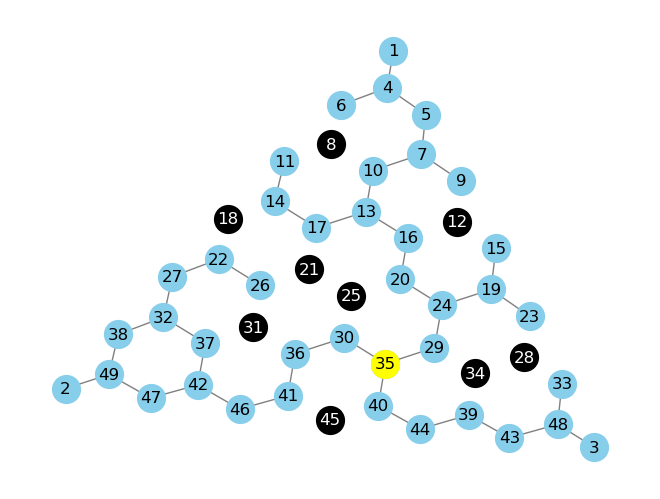

In [49]:
# Create the empty hex maze
empty_hex_maze = create_hex_maze()
barriers = []

# Generate a set of 9 random barriers until we get a good maze
is_good_maze = False
while not is_good_maze:
    # Start with an empty hex maze (no barriers)
    G = empty_hex_maze.copy()

    # Randomly select 9 barriers
    barriers = np.random.choice(POSSIBLE_BARRIERS, size=9, replace=False)
    
    # Add the barriers to the empty maze
    for barrier in barriers:
        G.remove_node(barrier)
        
    # Check if this is a good maze
    is_good_maze = is_valid_maze(G, complain=True)

# Print the barriers we chose
print("Barriers:", barriers)
# Once we get a good maze, print some stats about it
print("Shortest path between 1 and 2:", nx.shortest_path(G, source=1, target=2))
print("Length of path:", len(nx.shortest_path(G, source=1, target=2)))
print("Shortest path between 1 and 3:", nx.shortest_path(G, source=1, target=3))
print("Length of path:", len(nx.shortest_path(G, source=1, target=3)))
print("Shortest path between 2 and 3:", nx.shortest_path(G, source=2, target=3))
print("Length of path:", len(nx.shortest_path(G, source=2, target=3)))

print("Critical choice point(s):")
choice_points = find_all_critical_choice_points(G)
print(choice_points)

# Get the graph layout of the original maze
pos = nx.kamada_kawai_layout(empty_hex_maze)

# Draw the available hexes using this layout
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=400)

# Add the barriers in black
nx.draw_networkx_nodes(empty_hex_maze, pos, nodelist={b: b for b in barriers}, node_color='black', node_size=400)   
nx.draw_networkx_labels(empty_hex_maze, pos, labels={b: b for b in barriers}, font_color='white')

# Make the choice point(s) yellow
for choice_point in choice_points:
    nx.draw_networkx_nodes(empty_hex_maze, pos, nodelist=[choice_point], node_color='yellow', node_size=400)
        
plt.show()

In [66]:
from tqdm import tqdm

def generate_good_maze():
    '''
    Keep generating hex mazes until we get a good one! 

    Returns: the set of barriers for the good hex maze
    '''
    # Create the empty hex maze
    start_maze = create_hex_maze()
    barriers = set()

    # Generate a set of 9 random barriers until we get a good maze
    is_good_maze = False
    while not is_good_maze:
        # Start with an empty hex maze (no barriers)
        test_maze = start_maze.copy()

        # Randomly select 9 barriers
        barriers = set(np.random.choice(POSSIBLE_BARRIERS, size=9, replace=False))

        # Add the barriers to the empty maze
        for barrier in barriers:
            test_maze.remove_node(barrier)

        # Check if this is a good maze
        is_good_maze = is_valid_maze(test_maze)

    return barriers


def plot_hex_maze(barriers):
    ''' Given a set of barriers specifying a hex maze, plot the maze! '''
    
    # create an empty maze for graph layout
    base_hex_maze = create_hex_maze()
    
    # create our actual maze
    maze = base_hex_maze.copy()
    for barrier in barriers:
        maze.remove_node(barrier)

    # Get the graph layout of the original maze
    pos = nx.kamada_kawai_layout(base_hex_maze)

    # Draw the available hexes in our maze using this layout
    nx.draw(maze, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=400)

    # Add the barriers in black
    nx.draw_networkx_nodes(base_hex_maze, pos, nodelist={b: b for b in barriers}, node_color='black', node_size=400)   
    nx.draw_networkx_labels(base_hex_maze, pos, labels={b: b for b in barriers}, font_color='white')

    # Make the choice point(s) yellow
    choice_points = find_all_critical_choice_points(maze)
    for choice_point in choice_points:
        nx.draw_networkx_nodes(base_hex_maze, pos, nodelist=[choice_point], node_color='yellow', node_size=400)
    
    plt.show()


#lots_of_good_mazes = set()
#number_of_valid_configs = []

# run it 10,000 times! weeeeeeee
for i in tqdm(range(10000)):
    maze = frozenset(generate_good_maze())
    lots_of_good_mazes.add(maze)
    
    if i % 100 == 0:
        num_valid = len(lots_of_good_mazes)
        number_of_valid_configs.append(num_valid)
        print(f"After {i+120000} good mazes, {num_valid} are unique.")



  0%|                                         | 3/10000 [00:00<22:52,  7.28it/s]

After 120000 good mazes, 49321 are unique.


  1%|▍                                    | 102/10000 [00:32<1:12:05,  2.29it/s]

After 120100 good mazes, 49332 are unique.


  2%|▊                                      | 200/10000 [01:04<59:35,  2.74it/s]

After 120200 good mazes, 49341 are unique.


  3%|█▏                                     | 302/10000 [01:28<40:37,  3.98it/s]

After 120300 good mazes, 49352 are unique.


  4%|█▍                                   | 401/10000 [01:59<1:08:01,  2.35it/s]

After 120400 good mazes, 49367 are unique.


  5%|█▊                                   | 502/10000 [02:31<1:13:42,  2.15it/s]

After 120500 good mazes, 49380 are unique.


  6%|██▎                                    | 602/10000 [03:02<34:52,  4.49it/s]

After 120600 good mazes, 49386 are unique.


  7%|██▌                                  | 702/10000 [03:42<1:15:54,  2.04it/s]

After 120700 good mazes, 49400 are unique.


  8%|███▏                                   | 806/10000 [04:10<19:57,  7.68it/s]

After 120800 good mazes, 49415 are unique.


  9%|███▎                                 | 903/10000 [04:42<1:06:39,  2.27it/s]

After 120900 good mazes, 49424 are unique.


 10%|███▊                                  | 1002/10000 [05:12<37:17,  4.02it/s]

After 121000 good mazes, 49434 are unique.


 11%|████▏                                 | 1103/10000 [05:41<35:07,  4.22it/s]

After 121100 good mazes, 49442 are unique.


 12%|████▌                                 | 1203/10000 [06:13<53:49,  2.72it/s]

After 121200 good mazes, 49457 are unique.


 13%|████▉                                 | 1304/10000 [06:45<35:11,  4.12it/s]

After 121300 good mazes, 49471 are unique.


 14%|█████▎                                | 1403/10000 [07:17<25:11,  5.69it/s]

After 121400 good mazes, 49482 are unique.


 15%|█████▍                              | 1502/10000 [07:51<1:04:25,  2.20it/s]

After 121500 good mazes, 49496 are unique.


 16%|██████                                | 1603/10000 [08:16<31:04,  4.50it/s]

After 121600 good mazes, 49508 are unique.


 17%|██████▍                               | 1701/10000 [08:45<56:27,  2.45it/s]

After 121700 good mazes, 49519 are unique.


 18%|██████▍                             | 1801/10000 [09:18<1:05:29,  2.09it/s]

After 121800 good mazes, 49532 are unique.


 19%|███████▏                              | 1902/10000 [09:48<47:19,  2.85it/s]

After 121900 good mazes, 49540 are unique.


 20%|███████▏                            | 2001/10000 [10:19<1:18:02,  1.71it/s]

After 122000 good mazes, 49554 are unique.


 21%|███████▉                              | 2102/10000 [10:53<32:37,  4.04it/s]

After 122100 good mazes, 49562 are unique.


 22%|████████▎                             | 2202/10000 [11:30<38:25,  3.38it/s]

After 122200 good mazes, 49576 are unique.


 23%|████████▋                             | 2302/10000 [12:08<48:32,  2.64it/s]

After 122300 good mazes, 49586 are unique.


 24%|████████▋                           | 2402/10000 [12:43<1:00:23,  2.10it/s]

After 122400 good mazes, 49595 are unique.


 25%|█████████▌                            | 2502/10000 [13:13<42:46,  2.92it/s]

After 122500 good mazes, 49609 are unique.


 26%|█████████▉                            | 2601/10000 [13:45<21:44,  5.67it/s]

After 122600 good mazes, 49621 are unique.


 27%|██████████▎                           | 2702/10000 [14:21<30:34,  3.98it/s]

After 122700 good mazes, 49632 are unique.


 28%|██████████▋                           | 2802/10000 [14:49<46:35,  2.57it/s]

After 122800 good mazes, 49648 are unique.


 29%|███████████                           | 2901/10000 [15:19<38:54,  3.04it/s]

After 122900 good mazes, 49656 are unique.


 30%|███████████▍                          | 3002/10000 [15:48<21:24,  5.45it/s]

After 123000 good mazes, 49670 are unique.


 31%|███████████▊                          | 3101/10000 [16:20<54:15,  2.12it/s]

After 123100 good mazes, 49680 are unique.


 32%|████████████▏                         | 3202/10000 [16:56<26:33,  4.27it/s]

After 123200 good mazes, 49702 are unique.


 33%|████████████▌                         | 3302/10000 [17:30<36:28,  3.06it/s]

After 123300 good mazes, 49713 are unique.


 34%|████████████▉                         | 3405/10000 [17:57<37:41,  2.92it/s]

After 123400 good mazes, 49724 are unique.


 35%|█████████████▎                        | 3502/10000 [18:28<24:41,  4.39it/s]

After 123500 good mazes, 49744 are unique.


 36%|█████████████▋                        | 3603/10000 [19:04<29:38,  3.60it/s]

After 123600 good mazes, 49756 are unique.


 37%|██████████████                        | 3703/10000 [19:40<21:51,  4.80it/s]

After 123700 good mazes, 49771 are unique.


 38%|██████████████▍                       | 3802/10000 [20:06<55:50,  1.85it/s]

After 123800 good mazes, 49780 are unique.


 39%|██████████████▊                       | 3903/10000 [20:42<25:30,  3.98it/s]

After 123900 good mazes, 49786 are unique.


 40%|███████████████▏                      | 4002/10000 [21:14<30:39,  3.26it/s]

After 124000 good mazes, 49798 are unique.


 41%|██████████████▊                     | 4102/10000 [28:24<1:11:39,  1.37it/s]

After 124100 good mazes, 49803 are unique.


 42%|███████████████▉                      | 4204/10000 [31:52<27:09,  3.56it/s]

After 124200 good mazes, 49815 are unique.


 43%|████████████████▎                     | 4303/10000 [36:18<44:30,  2.13it/s]

After 124300 good mazes, 49819 are unique.


 44%|████████████████▋                     | 4402/10000 [39:36<33:53,  2.75it/s]

After 124400 good mazes, 49832 are unique.


 45%|█████████████████                     | 4501/10000 [53:49<29:33,  3.10it/s]

After 124500 good mazes, 49839 are unique.


 46%|████████████████▌                   | 4601/10000 [59:56<1:29:06,  1.01it/s]

After 124600 good mazes, 49850 are unique.


 47%|████████████████▉                   | 4702/10000 [1:00:26<20:35,  4.29it/s]

After 124700 good mazes, 49859 are unique.


 48%|███████████████▊                 | 4801/10000 [1:02:58<20:32:38, 14.23s/it]

After 124800 good mazes, 49862 are unique.


 49%|█████████████████▋                  | 4902/10000 [1:04:25<16:42,  5.09it/s]

After 124900 good mazes, 49875 are unique.


 50%|██████████████████                  | 5003/10000 [1:05:03<25:56,  3.21it/s]

After 125000 good mazes, 49885 are unique.


 51%|██████████████████▎                 | 5104/10000 [1:05:34<21:39,  3.77it/s]

After 125100 good mazes, 49900 are unique.


 52%|██████████████████▋                 | 5203/10000 [1:06:06<20:48,  3.84it/s]

After 125200 good mazes, 49915 are unique.


 53%|███████████████████                 | 5303/10000 [1:06:38<19:54,  3.93it/s]

After 125300 good mazes, 49923 are unique.


 54%|███████████████████▍                | 5404/10000 [1:07:08<11:51,  6.46it/s]

After 125400 good mazes, 49936 are unique.


 55%|███████████████████▊                | 5502/10000 [1:07:39<51:41,  1.45it/s]

After 125500 good mazes, 49951 are unique.


 56%|████████████████████▏               | 5602/10000 [1:08:11<22:39,  3.23it/s]

After 125600 good mazes, 49964 are unique.


 57%|████████████████████▌               | 5701/10000 [1:08:37<12:58,  5.52it/s]

After 125700 good mazes, 49973 are unique.


 58%|████████████████████▉               | 5803/10000 [1:09:09<29:07,  2.40it/s]

After 125800 good mazes, 49984 are unique.


 59%|█████████████████████▏              | 5901/10000 [1:09:44<26:13,  2.61it/s]

After 125900 good mazes, 49997 are unique.


 60%|█████████████████████▌              | 6003/10000 [1:10:16<27:51,  2.39it/s]

After 126000 good mazes, 50014 are unique.


 61%|█████████████████████▉              | 6102/10000 [1:10:49<18:14,  3.56it/s]

After 126100 good mazes, 50026 are unique.


 62%|██████████████████████▎             | 6202/10000 [1:11:21<22:46,  2.78it/s]

After 126200 good mazes, 50040 are unique.


 63%|██████████████████████▋             | 6301/10000 [1:11:49<18:40,  3.30it/s]

After 126300 good mazes, 50056 are unique.


 64%|███████████████████████             | 6404/10000 [1:12:23<21:46,  2.75it/s]

After 126400 good mazes, 50070 are unique.


 65%|███████████████████████▍            | 6502/10000 [1:12:51<23:56,  2.43it/s]

After 126500 good mazes, 50081 are unique.


 66%|███████████████████████▊            | 6602/10000 [1:13:28<20:07,  2.81it/s]

After 126600 good mazes, 50093 are unique.


 67%|████████████████████████            | 6701/10000 [1:13:54<10:51,  5.06it/s]

After 126700 good mazes, 50104 are unique.


 68%|████████████████████████▍           | 6801/10000 [1:14:29<12:33,  4.25it/s]

After 126800 good mazes, 50113 are unique.


 69%|████████████████████████▊           | 6902/10000 [1:14:58<15:41,  3.29it/s]

After 126900 good mazes, 50123 are unique.


 70%|█████████████████████████▏          | 7003/10000 [1:15:30<08:38,  5.78it/s]

After 127000 good mazes, 50131 are unique.


 71%|█████████████████████████▌          | 7103/10000 [1:15:59<20:56,  2.31it/s]

After 127100 good mazes, 50143 are unique.


 72%|█████████████████████████▉          | 7201/10000 [1:16:27<06:37,  7.05it/s]

After 127200 good mazes, 50154 are unique.


 73%|██████████████████████████▎         | 7302/10000 [1:16:56<12:14,  3.68it/s]

After 127300 good mazes, 50163 are unique.


 74%|██████████████████████████▋         | 7403/10000 [1:17:31<17:40,  2.45it/s]

After 127400 good mazes, 50169 are unique.


 75%|███████████████████████████         | 7503/10000 [1:17:58<07:27,  5.57it/s]

After 127500 good mazes, 50179 are unique.


 76%|███████████████████████████▎        | 7601/10000 [1:18:30<14:40,  2.73it/s]

After 127600 good mazes, 50195 are unique.


 77%|███████████████████████████▋        | 7703/10000 [1:18:59<13:00,  2.94it/s]

After 127700 good mazes, 50201 are unique.


 78%|████████████████████████████        | 7803/10000 [1:19:27<08:29,  4.31it/s]

After 127800 good mazes, 50212 are unique.


 79%|████████████████████████████▍       | 7901/10000 [1:19:58<09:12,  3.80it/s]

After 127900 good mazes, 50222 are unique.


 80%|████████████████████████████▊       | 8001/10000 [1:20:29<16:35,  2.01it/s]

After 128000 good mazes, 50230 are unique.


 81%|█████████████████████████████▏      | 8101/10000 [1:21:04<15:16,  2.07it/s]

After 128100 good mazes, 50240 are unique.


 82%|█████████████████████████████▌      | 8201/10000 [1:21:39<08:56,  3.35it/s]

After 128200 good mazes, 50254 are unique.


 83%|█████████████████████████████▉      | 8302/10000 [1:22:02<04:33,  6.20it/s]

After 128300 good mazes, 50267 are unique.


 84%|██████████████████████████████▏     | 8402/10000 [1:22:36<10:00,  2.66it/s]

After 128400 good mazes, 50277 are unique.


 85%|██████████████████████████████▌     | 8502/10000 [1:23:07<07:31,  3.32it/s]

After 128500 good mazes, 50291 are unique.


 86%|██████████████████████████████▉     | 8601/10000 [1:23:44<07:24,  3.15it/s]

After 128600 good mazes, 50300 are unique.


 87%|███████████████████████████████▎    | 8702/10000 [1:24:13<08:29,  2.55it/s]

After 128700 good mazes, 50308 are unique.


 88%|███████████████████████████████▋    | 8804/10000 [1:24:47<04:00,  4.97it/s]

After 128800 good mazes, 50318 are unique.


 89%|████████████████████████████████    | 8903/10000 [1:25:16<05:45,  3.18it/s]

After 128900 good mazes, 50329 are unique.


 90%|████████████████████████████████▍   | 9002/10000 [1:25:45<03:03,  5.44it/s]

After 129000 good mazes, 50340 are unique.


 91%|████████████████████████████████▊   | 9102/10000 [1:26:17<04:00,  3.73it/s]

After 129100 good mazes, 50350 are unique.


 92%|█████████████████████████████████▏  | 9202/10000 [1:26:50<03:29,  3.81it/s]

After 129200 good mazes, 50351 are unique.


 93%|█████████████████████████████████▍  | 9302/10000 [1:27:18<02:58,  3.90it/s]

After 129300 good mazes, 50359 are unique.


 94%|█████████████████████████████████▊  | 9405/10000 [1:27:49<01:49,  5.44it/s]

After 129400 good mazes, 50369 are unique.


 95%|██████████████████████████████████▏ | 9501/10000 [1:28:19<03:00,  2.76it/s]

After 129500 good mazes, 50384 are unique.


 96%|██████████████████████████████████▌ | 9602/10000 [1:28:51<02:26,  2.72it/s]

After 129600 good mazes, 50395 are unique.


 97%|██████████████████████████████████▉ | 9701/10000 [1:29:22<01:19,  3.78it/s]

After 129700 good mazes, 50401 are unique.


 98%|███████████████████████████████████▎| 9803/10000 [1:29:53<00:52,  3.73it/s]

After 129800 good mazes, 50412 are unique.


 99%|███████████████████████████████████▋| 9903/10000 [1:30:23<00:18,  5.25it/s]

After 129900 good mazes, 50423 are unique.


100%|███████████████████████████████████| 10000/10000 [1:30:52<00:00,  1.83it/s]


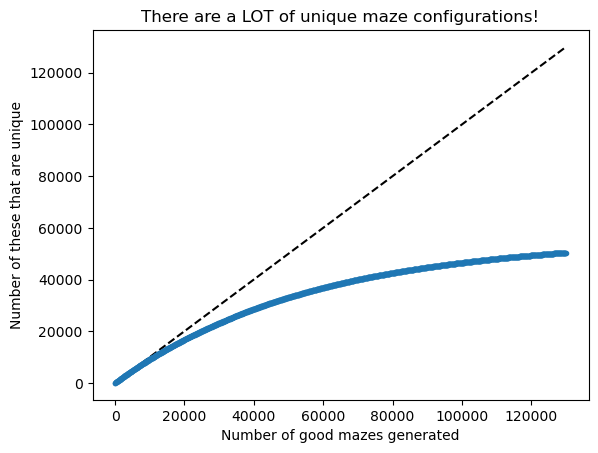

In [67]:
# How many possible configurations are there?
num_tries = 130000
timesteps = list(range(1, 130001, 100))

# Add a unity line for comparison
plt.plot([0, 130000], [0, 130000], 'k--')
# Add how many mazes we actually get
plt.plot(timesteps, number_of_valid_configs, '.')
plt.xlabel("Number of good mazes generated")
plt.ylabel("Number of these that are unique")
plt.title("There are a LOT of unique maze configurations!")
plt.show()


In [68]:
# save it!!!
import pickle

# Save the set to a pickle file
with open('set_of_good_mazes.pkl', 'wb') as file:
    pickle.dump(lots_of_good_mazes, file)
    
# Also save the stats to a pickle file
with open('number_of_valid_configs.pkl', 'wb') as file:
    pickle.dump(number_of_valid_configs, file)  